# Electricity Demand Forecasting

Time Series Modeling
In this project I am exploring time series modeling for Electricity Demand Forecasting for the state of California.

This notebook contains the SARIMAX modeling for the hourly demand aggregated data.  The data was cleaned and aggregated in the EF_EDA_CleanSplitAgg notebook.

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Module Import](#import)<br>
2. [Data Import](#read_data)<br>
    2A. [Data Split](#data_split)<br>
3. [Helper Functions](#helper)<br>
4. [Data Analysis](#analysis)<br>
    4A. [Stationarity Testing](#stationarity)<br>
    4B. [Autocorrelation](#autocorr)<br>
    4C. [Seasonal Decomposition](#seasonal_decomp)<br>
5. [Modeling](#modeling)<br>
    5A. [SARIMAX Without Exogenous Data](#SARI_NoX)<br>
    5A.1 [SARIMAX Without Exogenous Data Fit Plot 1](#plot-SARI_fit_zoom)<br>
    5A.2 [SARIMAX Without Exogenous Data Fit Plot 2](#plot-SARI_fit_wide)<br>
    5A.3 [SARIMAX Without Exogeneous Data - Forecast](#forecast-SARI_nox)<br>

    5B. [SARIMAX With Exogeneous Data](#model-SARIMAX-wexog)<br>
    5B.1 [SARIMAX With Exogeneous Data - Fit Plot Close](#plot-SARI_exog_fit_zoom)<br>
    5B.2 [SARIMAX With Exogeneous Data - Fit Plot 3 Month](#plot-SARI_exof_fit_wide)<br>
    5B.3 [SARIMAX With Exogeneous Data - Forecast](#forecast-SARI_exog)<br>

    5C. [SARIMAX With Extended Exogeneous Data](#model-SARI-xexog)<br>
    5C.1 [SARIMAX With Extended Exogeneous Data - Fit Plot Close](#plot-SARI_xexog_fit_zoom)<br>
    5C.2 [SARIMAX With Extended Exogeneous Data - Fit Plot 3 Month](#plot-SARI_xexof_fit_wide)<br>
    5C.3 [SARIMAX With Extended Exogeneous Data - Forecast](#forecast-SARI_xexog)<br>




----
### <a id='import'> 1. Module Import </a>

Import the modules used in this notebook.

----

In [1]:
import pandas as pd
import numpy as np
import re

import json
import datetime

import pickle
import warnings

from dateutil import parser

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.statespace.mlemodel
from statsmodels.tsa.stattools import adfuller
from collections import defaultdict


----
### <a id='read_data'>2. Data Import </a>

Read the data file created by the notebook EF_EDA_CleanSplitAgg.

----

In [2]:
data_file = '../data/big_demand_temp_train.csv'

In [3]:
full_df = pd.read_csv(data_file, index_col=0)
full_df.index = pd.DatetimeIndex(full_df.index)

In [4]:
full_df.head()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2015-07-01 08:00:00+00:00,38210,71.60,68.76,70.89,59.32,79.80,86.04,13845790.0,0,0,1,0,0,0,0,2
2015-07-01 09:00:00+00:00,35171,70.93,68.19,69.78,58.96,77.77,86.35,13845790.0,0,0,1,0,0,0,0,2
2015-07-01 10:00:00+00:00,33243,70.43,68.29,68.07,58.63,76.51,82.74,13845790.0,0,0,1,0,0,0,0,2
2015-07-01 11:00:00+00:00,31955,70.87,68.32,66.92,58.11,74.94,82.04,13845790.0,0,0,1,0,0,0,0,2
2015-07-01 12:00:00+00:00,31199,71.58,68.46,66.16,57.90,73.80,80.37,13845790.0,0,0,1,0,0,0,0,2


----

#### <a id='data_split'>2A. Data Split </a>

----

In [14]:
train_len = int(0.7 * full_df.shape[0])
window_len = int(0.1 * full_df.shape[0])

In [15]:
# Make the primary train/validation split
X_train = full_df.iloc[:train_len, :]

# Make intermediate trail windows for walk forward validation
X_walk1 = full_df.iloc[train_len:train_len+window_len, :]


In [16]:
# Look at the dataframe contents
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23006 entries, 2015-07-01 08:00:00+00:00 to 2018-02-13 21:00:00+00:00
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   demand         23006 non-null  int64  
 1   Los Angeles    23006 non-null  float64
 2   San Diego      23006 non-null  float64
 3   San Jose       23006 non-null  float64
 4   San Francisco  23006 non-null  float64
 5   Sacramento     23006 non-null  float64
 6   Fresno         23006 non-null  float64
 7   CA_pop         23006 non-null  float64
 8   Mon            23006 non-null  int64  
 9   Tue            23006 non-null  int64  
 10  Wed            23006 non-null  int64  
 11  Thur           23006 non-null  int64  
 12  Fri            23006 non-null  int64  
 13  Sat            23006 non-null  int64  
 14  Sun            23006 non-null  int64  
 15  DOW            23006 non-null  int64  
dtypes: float64(7), int64(9)
memory usage: 3.0 MB


----

### <a id='helper'>3. Helper Functions </a>

----

In [17]:
import sys
sys.path.append('../src')
from EF_tools import test_stationarity, order_sweep, top_results

### <a id='analysis'>4. Data Analysis </a>

#### <a id='stationarity'>4A. Stationarity Testing </a>

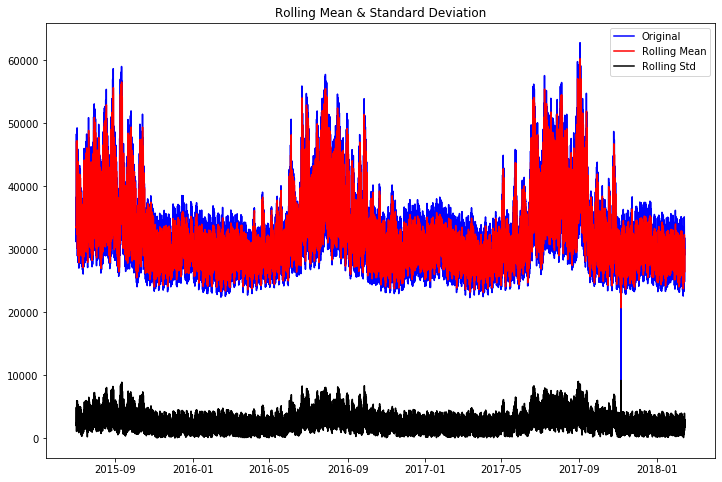

Results of Dickey-Fuller Test:
p-value = 0.0002. The series is likely stationary.
Test Statistic                    -4.499275
p-value                            0.000197
#Lags Used                        20.000000
Number of Observations Used    22985.000000
Critical Value (1%)               -3.430635
Critical Value (5%)               -2.861666
Critical Value (10%)              -2.566837
dtype: float64


In [18]:
test_stationarity(X_train.demand, window=8)

####  <a id='autocorr'>4B. Autocorrelation</a>

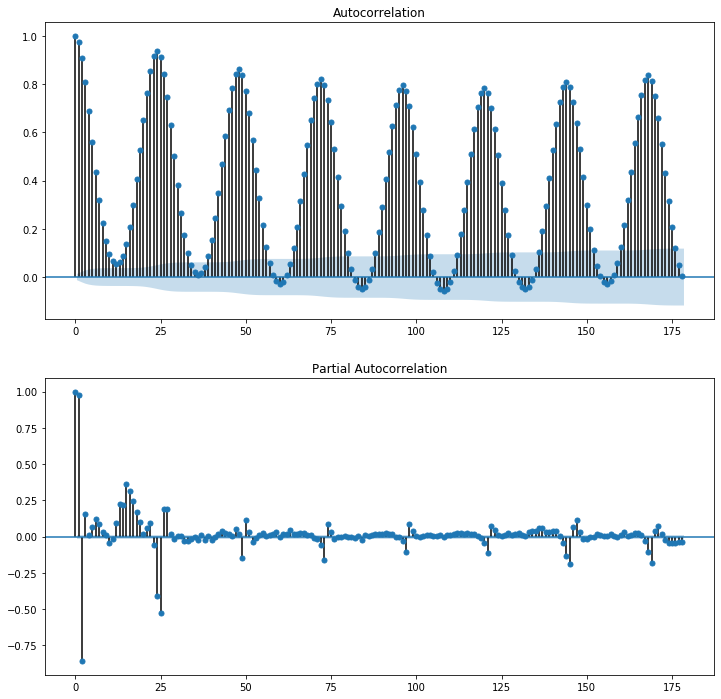

In [19]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X_train['demand'], lags=24*7+10, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X_train['demand'], lags=24*7+10, ax=ax2)# , lags=40

####  <a id='seasonal_decomp'>4C. Seasonal Decomposition</a>

In [20]:
# Do seasonal decopostion on the weekly periodic features
decomp_data = seasonal_decompose(X_train.demand.values[:10000], period=24, model='additive')

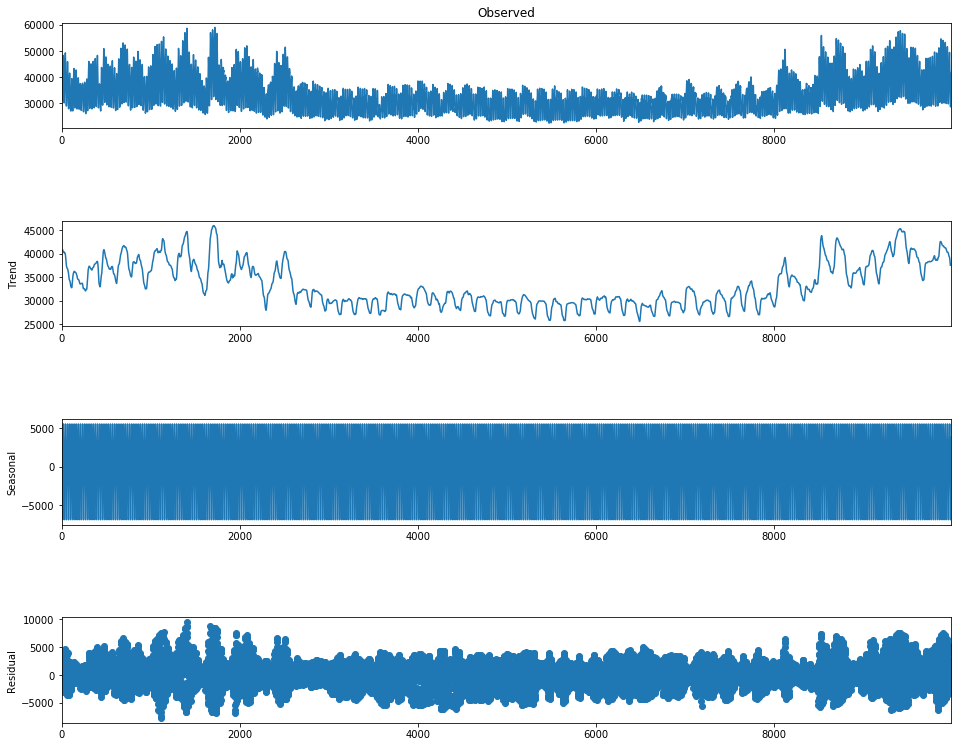

In [21]:
fig = decomp_data.plot()
fig.set_size_inches(15, 12)

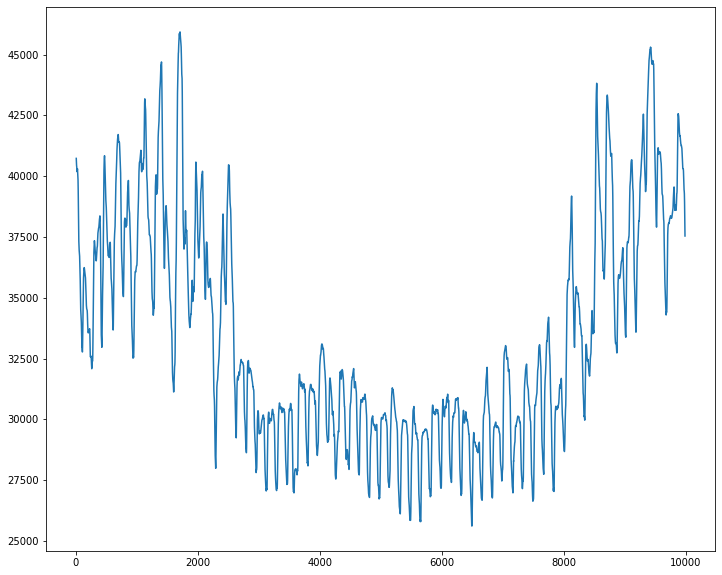

In [22]:
# Plot a closeup of the seasonal component
fig = plt.figure(figsize=[12,10])
plt.plot(decomp_data.trend[:10000])

### <a id='modeling'>5. Modeling </a>

#### <a id='SARI_NoX'>5A. SARIMAX Without Exogeneous Data </a>

In [24]:
# Define the model for SARIMAX just using the demand data
seasonal_model1 = SARIMAX(X_train['demand'], simple_differencing=True, \
    order=(4, 0, 2), seasonal_order=(1,0,0,24))

res1 = seasonal_model1.fit()

/home/michael/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/michael/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/michael/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [25]:
print(res1.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              demand   No. Observations:                23006
Model:             SARIMAX(4, 0, 2)x(1, 0, [], 24)   Log Likelihood             -174530.175
Date:                             Tue, 07 Apr 2020   AIC                         349076.349
Time:                                     16:56:59   BIC                         349140.697
Sample:                                 07-01-2015   HQIC                        349097.260
                                      - 02-13-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.5850      0.004    603.500      0.000       2.577       2.593
ar.L2         -2.1056      

In [26]:
# Save the trained model
filename = 'SARIMAX_wo_exog.sav'
pickle.dump(seasonal_model1, open(filename, 'wb'))

In [27]:
demand_hat = res1.fittedvalues

##### <a id='plot-SARI_fit_zoom'>5A.1 SARIMAX Without Exogeneous Data - Fit Plot Close </a>

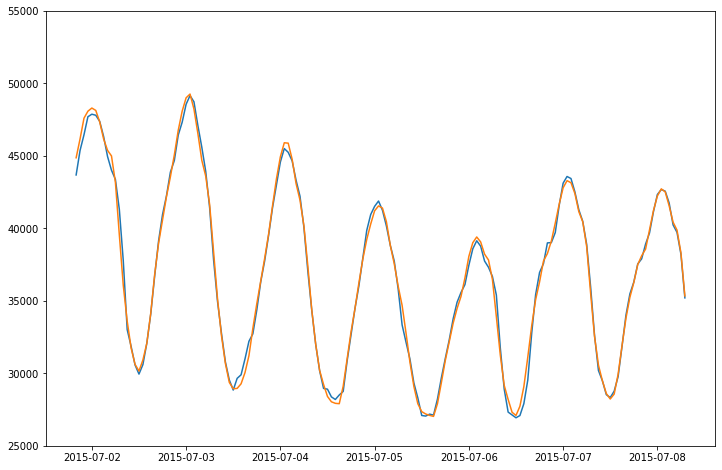

In [28]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(25000, 55000)

plt.plot(demand_hat[12:168])
plt.plot(X_train.index[12:168], X_train['demand'].values[12:168])

##### <a id='plot-SARI_fit_wide'>5A.2 SARIMAX Without Exogeneous Data - Fit Plot 3 Months  </a>

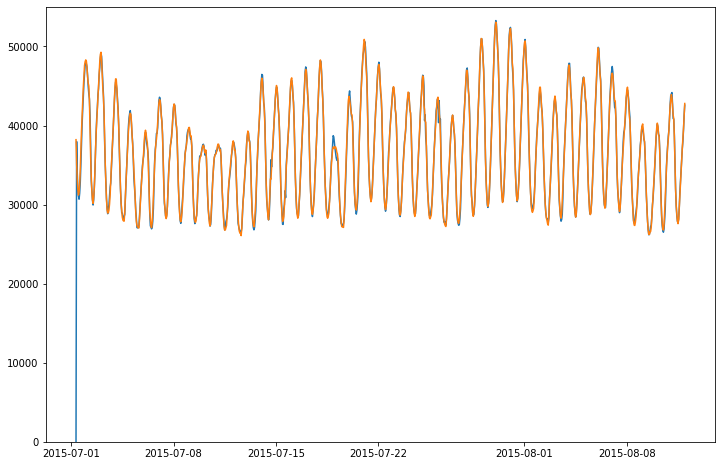

In [29]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 55000)

plt.plot(demand_hat[:1000])
actual = X_train['demand'].values[12:1012]
plt.plot(X_train.index[0:1000], X_train['demand'].values[0:1000])

----
----

##### <a id='forecast-SARI_nox'>5A.3 SARIMAX Without Exogeneous Data - Forecast </a>

----

In [30]:
predict_steps = 168*3
predict1 = res1.get_forecast(predict_steps)
pred_ci1 = predict1.conf_int(alpha=0.5)
pred_vals1 = predict1.predicted_mean

No handles with labels found to put in legend.


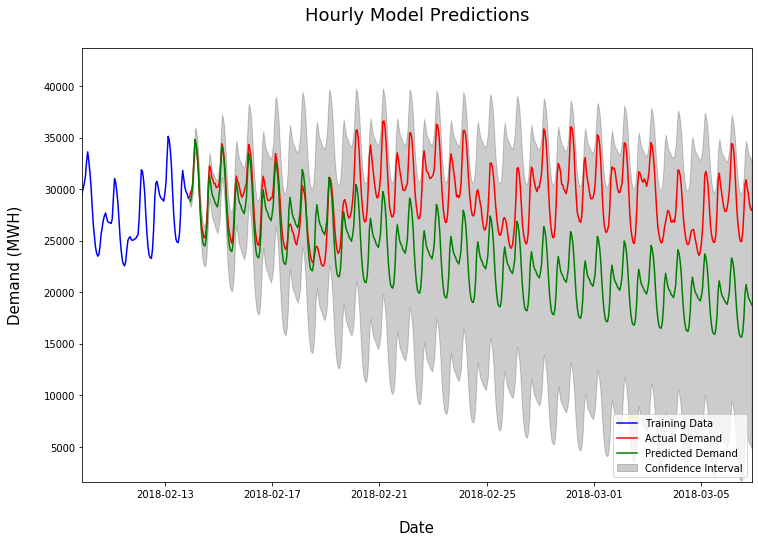

In [31]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)

date_list = X_train.index

low_values = pred_ci1.iloc[:, 0].values
high_values = pred_ci1.iloc[:, 1].values
pred_times1 = pred_ci1.index

plt.title('Hourly Model Predictions\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Demand (MWH)\n', fontsize=15)
plt.legend(loc='lower right')


plt.xlim(min(date_list[int(len(date_list) - 24*4) :]), max(pred_times1))
plt.ylim(0.9*min(low_values), 1.1*max(high_values))


#plt.plot(demand_hat[:1000])
p1 = plt.plot(X_train.index, X_train['demand'].values, c='b', label='Training Data')
p2 = plt.plot(X_walk1.index, X_walk1['demand'].values, c='r', label='Actual Demand')
p3 = plt.plot(pred_times1, pred_vals1.values, c='g', label='Predicted Demand')


p4 = plt.fill_between(pred_times1, low_values, high_values, color='k', alpha=0.2, label='Confidence Interval')

plt.legend( loc='lower right')

plt.savefig('daily_pred.png', Transparent=True)

In [32]:
residuals2 = [abs(X_walk1['demand'].values[x] - pred_vals1.values[x])/X_walk1['demand'].values[x]*100 for x in range(len(pred_vals1))]

In [33]:
mape1 = np.mean(residuals2[:3*168])
print(mape1)

20.02791685811225


No handles with labels found to put in legend.
/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


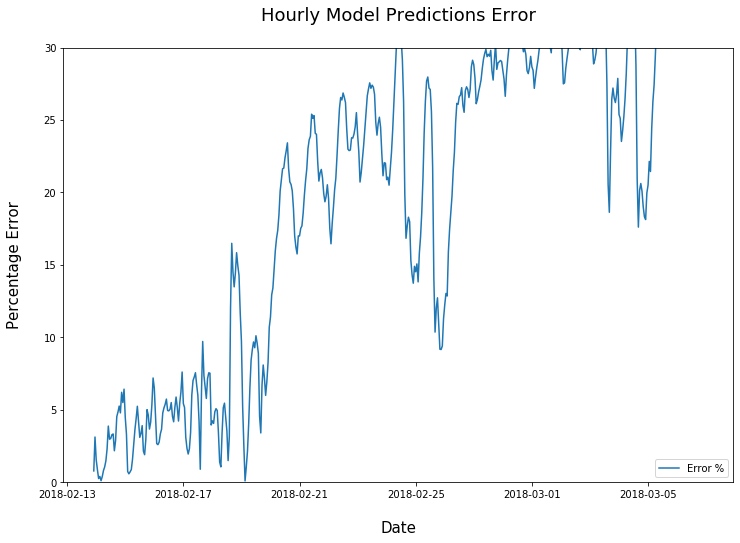

In [34]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

plt.title('Hourly Model Predictions Error\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Percentage Error\n', fontsize=15)
plt.legend(loc='lower right')

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)

plt.plot(pred_times1, residuals2, label='Error %')
plt.ylim(0, 30)

plt.legend( loc='lower right')

plt.savefig('daily_pred_error_pct.png', Transparent=True)

In [35]:
print(res1.aic, res1.bic, res1.mse)

349076.34929312824 349140.6973757719 291319.3877427149


#### <a id='model-SARIMAX-wexog'>5B. SARIMAX With Exogeneous Data </a>

In [36]:
# The trailing columns are city temperatures and state population
important_cities = ['Los Angeles', 'Fresno']
city_temps_pop = X_train[important_cities]

In [37]:
# Define the seasonal model with exogenous data
seasonal_model2 = SARIMAX(X_train['demand'], exog=X_train[important_cities], \
    order=(5, 0, 1), seasonal_order=(1,0,0,24))
res2 = seasonal_model2.fit()

/home/michael/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/michael/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/michael/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [38]:
print(res2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              demand   No. Observations:                23006
Model:             SARIMAX(5, 0, 1)x(1, 0, [], 24)   Log Likelihood             -174616.880
Date:                             Tue, 07 Apr 2020   AIC                         349253.759
Time:                                     17:08:17   BIC                         349334.194
Sample:                                 07-01-2015   HQIC                        349279.898
                                      - 02-13-2018                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Los Angeles    26.1479      3.224      8.110      0.000      19.829      32.467
Fresno        -18.8853  

In [39]:
# Save the trained model
filename = 'SARIMAX_w_exog.sav'
pickle.dump(seasonal_model2, open(filename, 'wb'))

In [40]:
demand_hat2 = res2.fittedvalues

##### <a id='plot-SARI_exog_fit_zoom'>5B.1 SARIMAX With Exogeneous Data - Fit Plot Close </a>

No handles with labels found to put in legend.
/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


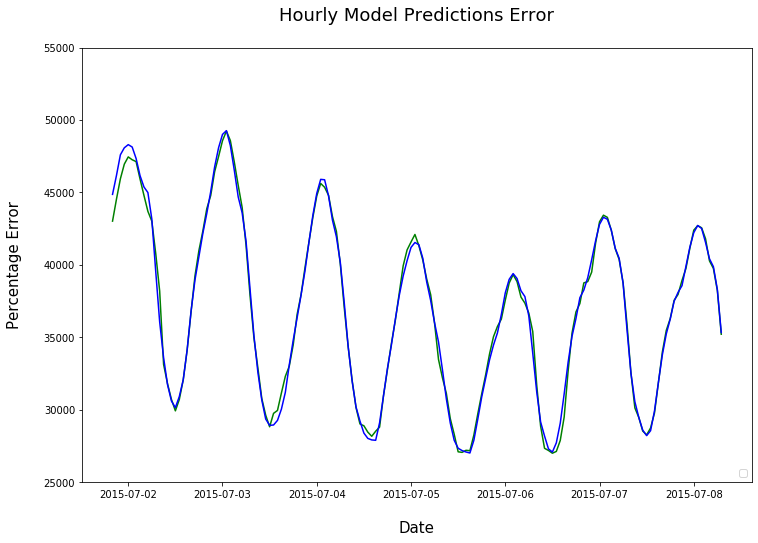

In [41]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

plt.title('Hourly Model Predictions Error\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Percentage Error\n', fontsize=15)
plt.legend(loc='lower right')

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.ylim(25000, 55000)

plt.plot(demand_hat2[12:168], c='g')
plt.plot(X_train.index[12:168], X_train['demand'].values[12:168], c='b')
plt.savefig('hourly_pred_wexog.png', Transparent=True)

----
----

##### <a id='plot-SARI_exof_fit_wide'>5B.2 SARIMAX With Exogeneous Data - Fit Plot 3 Month </a>

----

No handles with labels found to put in legend.
/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


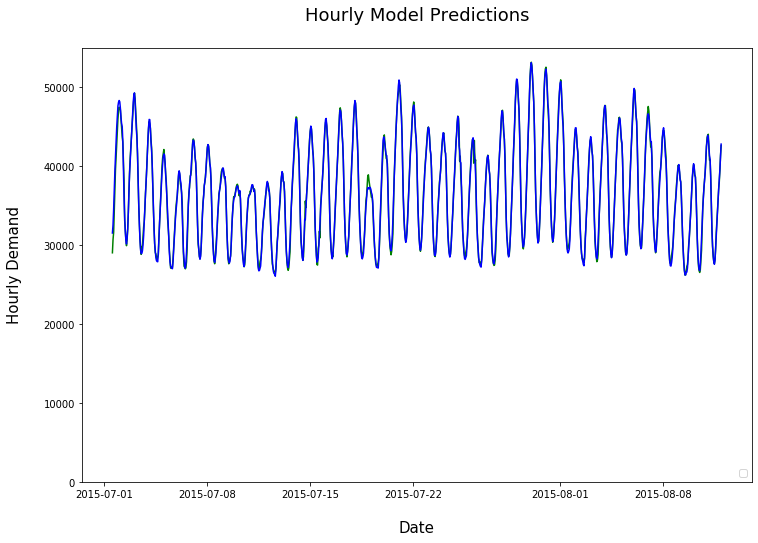

In [42]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

plt.title('Hourly Model Predictions\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Hourly Demand\n', fontsize=15)
plt.legend(loc='lower right')

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.ylim(0, 55000)

plt.plot(demand_hat2[5:1000], c='g')
actual = X_train['demand'].values[12:1012]
plt.plot(X_train.index[5:1000], X_train['demand'].values[5:1000], c='b')

----
----
##### <a id='forecast-SARI_exog'>5B.3 SARIMAX With Exogeneous Data - Forecast  </a>
----

In [43]:
predict_steps = 168*3
predict2 = res2.get_forecast(predict_steps, 
                exog=X_walk1[important_cities].values[:predict_steps, :])
pred_ci2 = predict2.conf_int(alpha=0.5)
pred_vals2 = predict2.predicted_mean

In [44]:
aic2 = res2.aic

No handles with labels found to put in legend.
/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


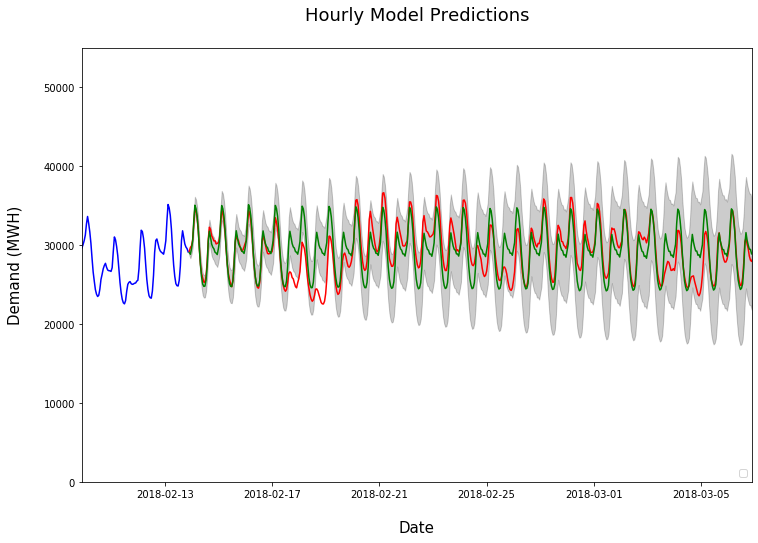

In [45]:
fig = plt.figure(figsize=[12, 8])

fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

plt.title('Hourly Model Predictions\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Demand (MWH)\n', fontsize=15)
plt.legend(loc='lower right')

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)

plt.ylim(0, 55000)
date_list = X_train.index

low_values = pred_ci2.iloc[:, 0].values
high_values = pred_ci2.iloc[:, 1].values
pred_times2 = pred_ci2.index

plt.xlim(min(date_list[int(len(date_list) - 24*4) :]), max(pred_times2))
#plt.ylim(min(low_values), max(high_values))

#plt.plot(demand_hat[:1000])
plt.plot(X_train.index, X_train['demand'].values, label='Training Demand', c='b')
plt.plot(X_walk1.index, X_walk1['demand'].values, c='r', label='Actual Demand')
plt.plot(pred_times2, pred_vals2.values, c='g', label='Predicted Demand')


plt.fill_between(pred_times2, low_values, high_values, color='k', alpha=0.2, label='Confidence Interval')
plt.savefig('hourly_forecast_wexog.png', Transparent=True)

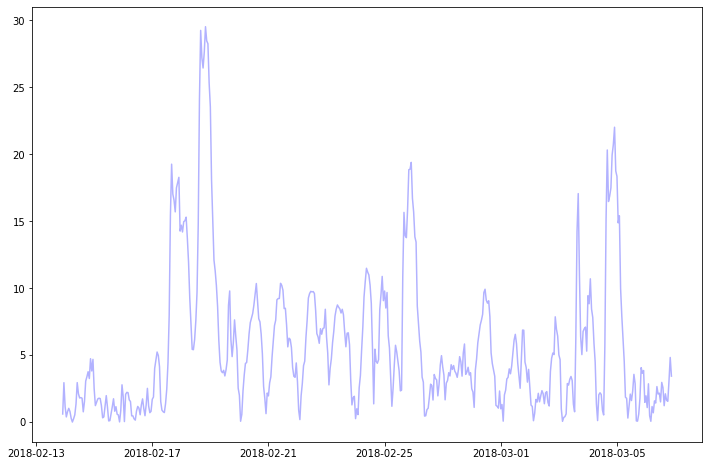

In [46]:
fig = plt.figure(figsize=[12, 8])
residuals2 = [abs(X_walk1['demand'].values[x] - pred_vals2.values[x]) / X_walk1['demand'].values[x] * 100 for x in range(len(pred_vals2))]
plt.plot(pred_times2, residuals2, c='b', alpha=0.3)


In [47]:
mape2 = np.mean(residuals2[:3*168])
print(mape2)

5.667279472752319


----
----
#### <a id='model-SARI-xexog'>5C.SARIMAX With Extended Exogeneous Data </a>
----

In [48]:
# Use all the dummies for the day of the week but don't use the DOW column
all_exog_dat = X_train.columns[1:-1]

In [50]:
# Define the seasonal model with exogenous data
seasonal_model3 = SARIMAX(X_train['demand'], exog=X_train[all_exog_dat], simple_differencing=True, \
    order=(5, 0, 1), seasonal_order=(1,0,0,24))

res3 = seasonal_model3.fit()
print(res3.summary())

/home/michael/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/michael/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/michael/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                      SARIMAX Results                                      
Dep. Variable:                              demand   No. Observations:                23006
Model:             SARIMAX(5, 0, 1)x(1, 0, [], 24)   Log Likelihood             -183806.679
Date:                             Tue, 07 Apr 2020   AIC                         367657.357
Time:                                     17:28:52   BIC                         367834.314
Sample:                                 07-01-2015   HQIC                        367714.862
                                      - 02-13-2018                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Los Angeles     148.1911      6.618     22.392      0.000     135.220     161.162
San Diego       -6

In [51]:
# Save the trained model
filename = 'SARIMAX_w_xexog.sav'
pickle.dump(seasonal_model3, open(filename, 'wb'))

In [52]:
predict_steps = min([168*20, X_walk1.shape[0]])
predict3 = res3.get_forecast(predict_steps, 
                exog=X_walk1[all_exog_dat].values[:predict_steps, :])
pred_ci3 = predict3.conf_int(alpha=0.5)
pred_vals3 = predict3.predicted_mean

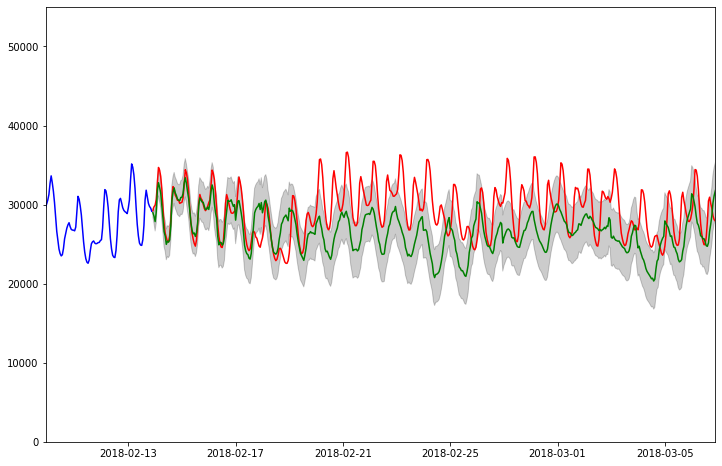

In [53]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 55000)
date_list = X_train.index

low_values = pred_ci3.iloc[:, 0].values
high_values = pred_ci3.iloc[:, 1].values
pred_times3 = pred_ci3.index

plt.xlim(min(date_list[int(len(date_list) - 24*4) :]), max(pred_times2))
#plt.ylim(min(low_values), max(high_values))

#plt.plot(demand_hat[:1000])
plt.plot(X_train.index[-3*168:], X_train['demand'].values[-3*168:], c='b')
plt.plot(X_walk1.index[:3*168], X_walk1['demand'].values[:3*168], c='r')
plt.plot(pred_times3, pred_vals3.values, c='g')


plt.fill_between(pred_times3, low_values, high_values, color='k', alpha=0.2)

(0, 50)

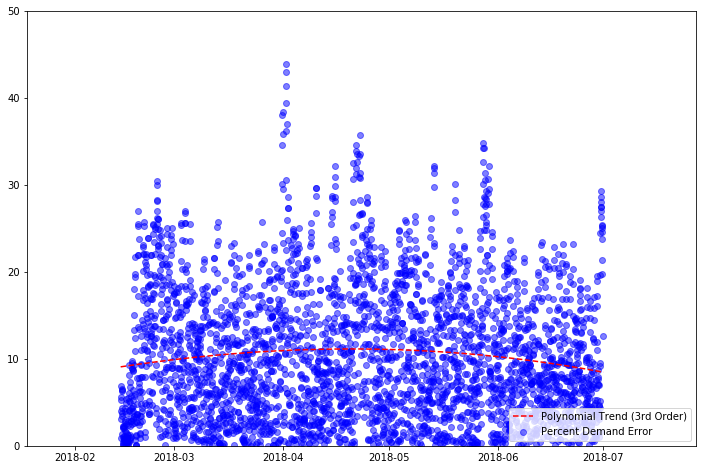

In [54]:
fig = plt.figure(figsize=[12, 8])
residuals3 = [abs(X_walk1['demand'].values[x] - pred_vals3.values[x])/ \
              X_walk1['demand'].values[x] * 100 for x in range(len(pred_vals3))]

timestamps = [int(x.timestamp()) for x in X_walk1.index]
z = np.polyfit(timestamps, residuals3, 3)
poly_trend = np.poly1d(z)
trend = [poly_trend(x) for x in timestamps]

plt.scatter(pred_times3, residuals3, c='b', alpha=0.5, label='Percent Demand Error')
plt.plot(X_walk1.index, trend,"r--", label='Polynomial Trend (3rd Order)')
plt.legend(loc='lower right')
plt.ylim(0, 50)

In [55]:
mape3 = np.mean(residuals3[:3*168])
print(mape3)

10.73227201458753
